## Recover info about movie directos (code de Juliette)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
from transformers import pipeline
import ast
import plotly.express as px
import plotly.graph_objects as go

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [9]:
DATA_FOLDER_PATH = 'src/data/raw_data/'
CLUSTER_JSON_PATH =  'src/data/clusters.json'

In [30]:
from src.data.data_loader import load_movies_metadata, load_char_metadata, load_plot_summaries, load_tvtropes_data, load_name_clusters

In [33]:
movies_metadata_df = load_movies_metadata(DATA_FOLDER_PATH)
char_metadata_df = load_char_metadata(DATA_FOLDER_PATH)
plot_summaries_df = load_plot_summaries(DATA_FOLDER_PATH)
tvtropes_df = load_tvtropes_data(DATA_FOLDER_PATH)
name_clusters_df = load_name_clusters(DATA_FOLDER_PATH)

In [34]:
from src.utils.methods import get_intersection

movies_metadata_df, char_metadata_df, intersection_ids = get_intersection(movies_metadata_df, char_metadata_df)

KeyboardInterrupt: 

### Preprocessing data (clean languages, genre etc)

In [28]:
def extract_names_from_tuples(languages):
    lang_dict = ast.literal_eval(languages)
    return list(lang_dict.values())

In [35]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(extract_names_from_tuples)
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(extract_names_from_tuples)
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(extract_names_from_tuples)

In [36]:
with open(CLUSTER_JSON_PATH, 'r') as file:
    data = json.load(file)

In [37]:
languages_cluster = data['Languages']
countries_cluster = data['Countries']
genres_cluster = data['Genres']

In [38]:
def map_cluster(mapping, elem):
    for generic, variants in mapping.items():
        if elem in variants:
            return generic
    return elem

In [39]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(lambda x: list(dict.fromkeys([map_cluster(languages_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(lambda x: list(dict.fromkeys([map_cluster(countries_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(lambda x: list(dict.fromkeys([map_cluster(genres_cluster, elem) for elem in x]).keys()))

In [40]:
from src.data.data_loader import load_movies_director, load_movies_metadata

In [41]:
movies_director = load_movies_director("src/data/external_data/")
movies_director.head()
movies_director.rename(columns={'gender': 'director_gender'}, inplace=True)

In [42]:
movies_director['wikipedia_movie_id'] = movies_director['wikipedia_movie_id'].astype(int)

In [43]:
 # Create new dataframe combining data of movies_metadata and movies_director
movies_directors_combined = movies_metadata_df.join(movies_director.set_index('wikipedia_movie_id'), on='wikipedia_movie_id')
movies_directors_combined = movies_directors_combined[movies_directors_combined['director_gender'].notna()]

movies_directors_combined.to_csv('src/data/external_data/movies_directors_combined.csv', index=False)

## Genres according to movie director gender

In [44]:
movies_directors_combined.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,director_name,director_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States],"[Thriller, Science Fiction, Horror, Adventure,...",John Carpenter,M
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],[Thriller],Donald Cammell,M
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],Robert van Ackeren,M


Splitting df by the gender of the director

In [48]:
movies_director_f = movies_directors_combined[movies_directors_combined['director_gender']=='F']
movies_director_m = movies_directors_combined[movies_directors_combined['director_gender']=='M']

now, lets study genre distribution across movies made by women

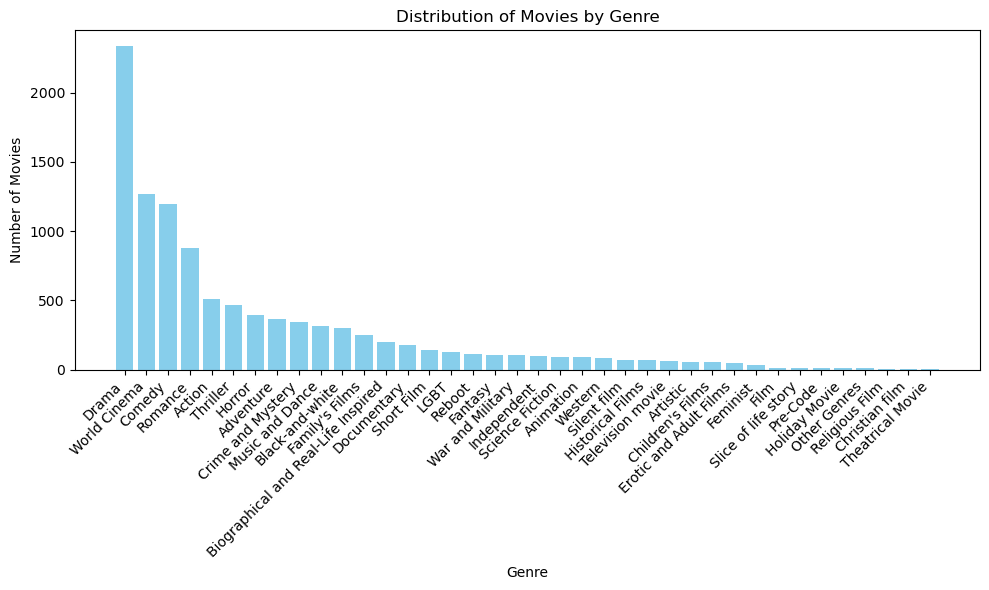

In [51]:
all_genres = movies_director_f['movie_genres'].copy()
all_genres = [genre for sublist in movies_director_f['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 2]

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

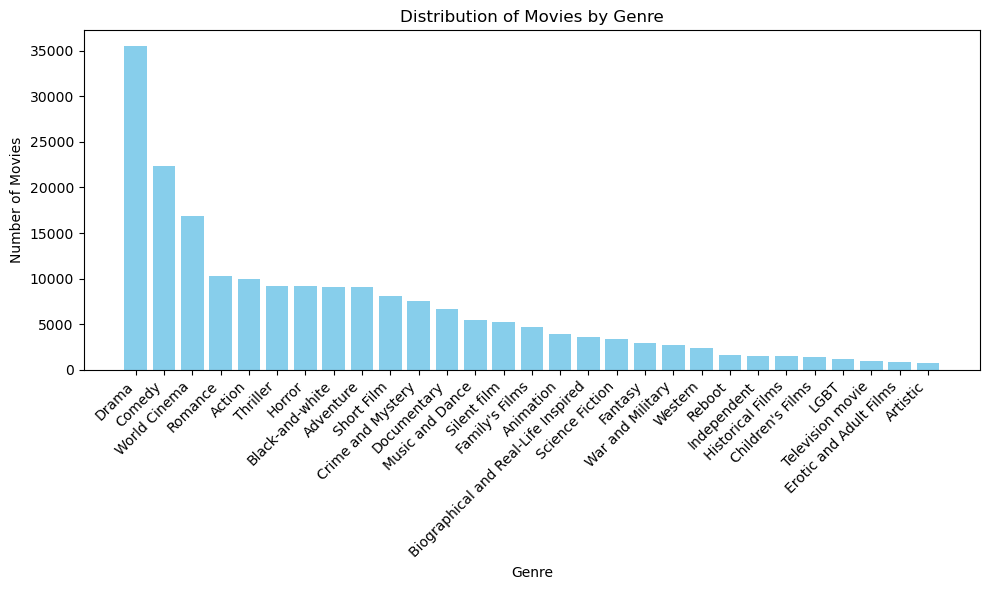

In [52]:
all_genres = movies_director_m['movie_genres'].copy()
all_genres = [genre for sublist in movies_metadata_df['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 500]

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

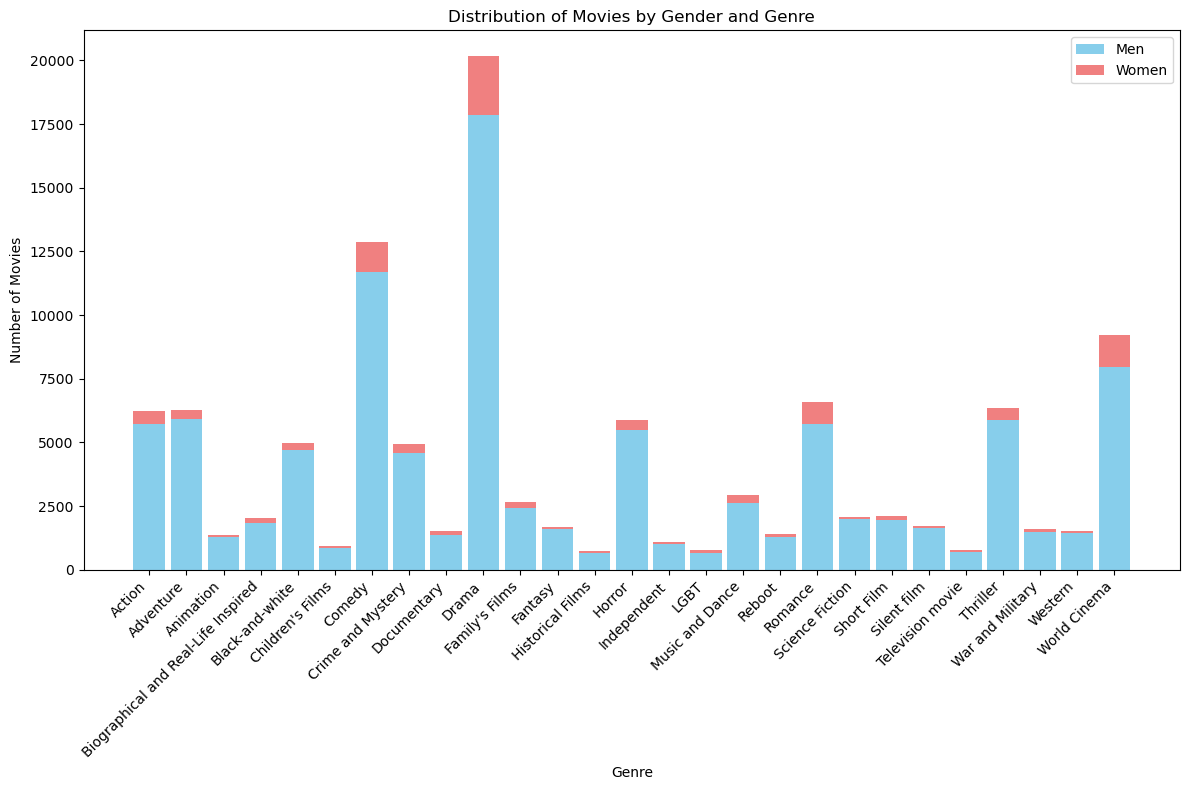

In [63]:
#male director movies
all_genres_m = [genre for sublist in movies_director_m['movie_genres'] for genre in sublist]
genre_counts_m = Counter(all_genres_m)
genres_df_m = pd.DataFrame(genre_counts_m.items(), columns=['Genre', 'Count_m'])

#female director movies
all_genres_f = [genre for sublist in movies_director_f['movie_genres'] for genre in sublist]
genre_counts_f = Counter(all_genres_f)
genres_df_f = pd.DataFrame(genre_counts_f.items(), columns=['Genre', 'Count_f'])

#merge the male and female genre dataframes on the Genre column
genre_df = pd.merge(genres_df_m, genres_df_f, on='Genre', how='outer').fillna(0)

#filter genres with more than 500 movies
genre_df['Total'] = genre_df['Count_m'] + genre_df['Count_f']
genre_df = genre_df[genre_df['Total'] > 500] 

plt.figure(figsize=(12, 8))
bar_width = 0.85
bar_positions = range(len(genre_df))

plt.bar(bar_positions, genre_df['Count_m'], width=bar_width, label='Men', color='skyblue')
plt.bar(bar_positions, genre_df['Count_f'], width=bar_width, label='Women', color='lightcoral', bottom=genre_df['Count_m'])

plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Gender and Genre')
plt.xticks(bar_positions, genre_df['Genre'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


We observe that drama, comedy and world cinema consitute the first three genres produced by women. 
Now, let's see in terms of proportion of movies produced by women vs men.

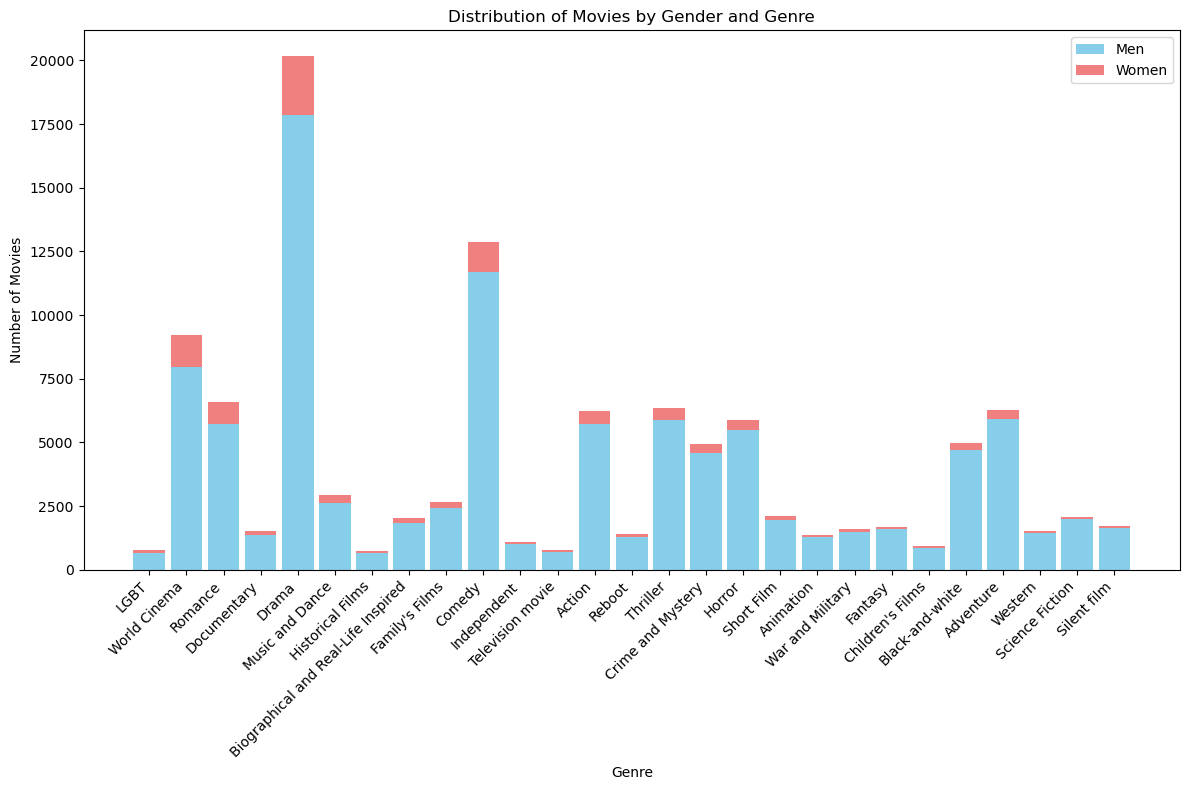

In [67]:
# Calculate the proportion of movies directed by women
genre_df['Proportion_f'] = genre_df['Count_f'] / genre_df['Total']

# Sort genres by the proportion of women directors in descending order
genre_df = genre_df.sort_values(by='Proportion_f', ascending=False)

# Sort genres by the number of movies directed by women in descending order
# genre_df = genre_df.sort_values(by='Count_f', ascending=False)

genre_df = genre_df[genre_df['Total'] > 500] 

plt.figure(figsize=(12, 8))
bar_width = 0.85
bar_positions = range(len(genre_df))

plt.bar(bar_positions, genre_df['Count_m'], width=bar_width, label='Men', color='skyblue')
plt.bar(bar_positions, genre_df['Count_f'], width=bar_width, label='Women', color='lightcoral', bottom=genre_df['Count_m'])

plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Gender and Genre')
plt.xticks(bar_positions, genre_df['Genre'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Creation of a csv file with all the movies produced by women grouped by genre

In [ ]:
# Create a list to hold the data for each genre
female_movies_by_genre = []

# Assuming `movies_director_f` contains the movies directed by women with columns 'movie_genres' and 'movie_title'
for genre in genre_df['Genre']:  # genre_df is sorted by proportion of women-directed movies
    movies_in_genre = movies_director_f[
        movies_director_f['movie_genres'].apply(lambda genres: genre in genres)
    ]['movie_name'].tolist()
    female_movies_by_genre.append((genre, movies_in_genre))

# Create a DataFrame with the results
female_movies_df = pd.DataFrame(female_movies_by_genre, columns=['Genre', 'Female_Directed_Movies'])

# Display the DataFrame
pd.set_option('display.max_colwidth', None)  # Ensures long lists are fully displayed
print(female_movies_df)

female_movies_df.to_csv('female_directed_movies_by_genre.csv', index=False)

## More detailed graph (chatGPT)

In [71]:
import pandas as pd
from collections import Counter
import plotly.graph_objects as go

# Assuming movies_director_m and movies_director_f have a column 'movie_genres'
# Flatten the list of genres for movies directed by men
all_genres_m = [genre for sublist in movies_director_m['movie_genres'] for genre in sublist]
genre_counts_m = Counter(all_genres_m)

genres_df_m = pd.DataFrame(genre_counts_m.items(), columns=['Genre', 'Count_m'])

# Flatten the list of genres for movies directed by women
all_genres_f = [genre for sublist in movies_director_f['movie_genres'] for genre in sublist]
genre_counts_f = Counter(all_genres_f)

genres_df_f = pd.DataFrame(genre_counts_f.items(), columns=['Genre', 'Count_f'])

# Merge the male and female genre dataframes on the Genre column
genre_df = pd.merge(genres_df_m, genres_df_f, on='Genre', how='outer').fillna(0)

# Calculate the total count and filter genres with more than 500 movies
genre_df['Total'] = genre_df['Count_m'] + genre_df['Count_f']
genre_df = genre_df[genre_df['Total'] > 500]

# Calculate the proportion of movies directed by women
genre_df['Proportion_f'] = genre_df['Count_f'] / genre_df['Total']

# Sort genres by the proportion of women directors in descending order
genre_df = genre_df.sort_values(by='Proportion_f', ascending=False)

# Create an interactive bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=genre_df['Genre'],
    y=genre_df['Count_m'],
    name='Men',
    marker_color='skyblue',
    hoverinfo='y',  # Show only count on hover for this trace
))

fig.add_trace(go.Bar(
    x=genre_df['Genre'],
    y=genre_df['Count_f'],
    name='Women',
    marker_color='lightcoral',
    hoverinfo='y',  # Show only count on hover for this trace
    text=genre_df['Proportion_f'].apply(lambda x: f"{x:.2%}"),  # Add proportions as text
    textposition='auto',  # Show the text above the bars
))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Distribution of Movies by Gender and Genre (Proportion of Women Highlighted)',
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Number of Movies'),
    legend=dict(title='Director Gender'),
    hovermode="x unified"  # Shows hover info for both traces at the same time
)

# Add hovertemplate to display proportion of female-directed movies
fig.update_traces(
    hovertemplate="<b>Genre:</b> %{x}<br>" +
                  "<b>Female Proportion:</b> %{text}<br>" +
                  "<b>Count:</b> %{y}<br>"
)

fig.show()
